# BEE 4750 Homework 2: Dissolved Oxygen

**Name**:

**ID**:

> **Due Date**
>
> Friday, 09/22/23, 9:00pm

## Overview

### Instructions

This assignment asks you to use a simulation model for dissolved oxygen
to assess the impacts of two wastewater streams, including minimum
treatment levels and the impact of uncertain environmental conditions.
You will also be asked to identify a minimum distance for the addition
of a third discharge stream.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [189]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `~/github-classroom/BEE4750-FA23/hw02-josephjoonlee`


In [190]:
using Plots
using LaTeXStrings
using Distributions

## Problems (Total: 40 Points)

A river which flows at 6 km/d is receiving waste discharges from two
sources which are 15 km apart, as shown in
<a href="#fig-river" class="quarto-xref">Figure 1</a>. The oxygen
reaeration rate is 0.55 day<sup>-1</sup>, and the decay rates of CBOD
and NBOD are are 0.55 and 0.25 day<sup>-1</sup>, respectively. The
river’s saturated dissolved oxygen concentration is 10m g/L.

![Figure 1: Schematic of the
system](attachment:figures/river_diagram.png)

### Problem 1 (8 points)

If the characteristics of the river inflow and waste discharges are
given in <a href="#tbl-river" class="quarto-xref">Table 1</a>, write a
Julia model to compute the dissolved oxygen concentration from the first
wastewater discharge to an arbitrary distance `d` km downstream. Use
your model to compute the maximum dissolved oxygen concentration up to
50km downstream and how far downriver this maximum occurs.

|    Parameter     |            River Inflow |         Waste Stream 1 |         Waste Stream 2 |
|:----------------:|------------------------:|-----------------------:|-----------------------:|
|      Inflow      | 100,000 L/d | 10,000 L/d | 15,000 L/d |
| DO Concentration |                7.5 mg/L |                 5 mg/L |                 5 mg/L |
|       CBOD       |                  5 mg/L |                50 mg/L |                45 mg/L |
|       NBOD       |                  5 mg/L |                35 mg/L |                35 mg/L |

Table 1: River inflow and waste stream characteristics for Problem 1.

In [191]:
# Parameters

ka = 0.55 # rearation rate
kc = 0.35 # decay rate of CBOD
kn = 0.25 # decay rate of NBOD
U = 6 # km/day
C_s = 10 # saturated Concentration
C_river = 7.5 # mg/L 
Q_river = 100000 # L/day
C_waste1 = 5 # mg/L
Q_waste1 = 10000 # L/day
C_waste2 = 5 # mg/L
Q_waste2 = 15000 # L/day
B0_river = 5 # mg/L
N0_river = 5 # mg/L
B0_waste1 = 50
N0_waste1 = 35
B0_waste2 = 45
N0_waste2 = 35

# At x = 0, waste source mixes with river source

# Calculate Initial Conditions
C0 = (C_river * Q_river + C_waste1 * Q_waste1) / (Q_river + Q_waste1);
B0 = (B0_river * Q_river + B0_waste1 * Q_waste1) / (Q_river + Q_waste1);
N0 = (N0_river * Q_river + N0_waste1 * Q_waste1) / (Q_river + Q_waste1);

x = []; # list of x values
CDO = []; # list for Dissolved Oxygen Concentrations
CBOD = []; # list of Bio oxygen demands
NBOD = []; # list of NBOD


# Model from x = 1 to 14.9
for i = 0:0.1:14.9 # ends at 14.9 to prevent double counting of x = 15 in next for loop

    alpha_1 = exp(-ka * i / U);
    alpha_2 = (kc / (ka - kc)) * (exp(-kc * i / U) - alpha_1);
    alpha_3 = (kn / (ka - kn)) * (exp(-kn * i / U) - alpha_1);
    
    C = ((C_s * (1 - alpha_1)) + (C0 * alpha_1) - (B0 * alpha_2) - (N0 * alpha_3)); # calculates CDO
    B = B0 * exp(-kc * i / U); # calculates CBOD
    N = N0 * exp(-kn * i / U); # calculates NBOD

    append!(CDO, C); #Adds calculated Concentration to List of CDOs
    append!(CBOD, B);
    append!(NBOD, N);
    append!(x, i) #Adds x value
end

# Calculate new initial conditions at waste site 2 from conditions at x = 15

C0 = (last(CDO) * (Q_river + Q_waste1) + C_waste2 * Q_waste2) / (Q_river + Q_waste1 + Q_waste2);
B0 = (last(CBOD) * (Q_river + Q_waste1) + B0_waste2 * Q_waste2) / (Q_river + Q_waste1 + Q_waste2);
N0 = (last(NBOD) * (Q_river + Q_waste1) + N0_waste2 * Q_waste2) / (Q_river + Q_waste1 + Q_waste2);

# Model from x = 15 to 50 km

for i = 15:0.1:50
    alpha_1 = exp(-ka * (i-15) / U); # subtract 15 from i so that it starts calculation at i = 0
    alpha_2 = (kc / (ka - kc)) * (exp(-kc * (i-15) / U) - alpha_1);
    alpha_3 = (kn / (ka - kn)) * (exp(-kn * (i-15) / U) - alpha_1);

    C = ((C_s * (1 - alpha_1)) + (C0 * alpha_1) - (B0 * alpha_2) - (N0 * alpha_3)); # calculates CDO
    B = B0 * exp(-kc * (i-15) / U); # calculates BOD
    N = N0 * exp(-kn * (i-15) / U); # calculates NBOD


    append!(CDO, C); #Adds calculated Concentration to List of CDOs
    append!(CBOD, B);
    append!(NBOD, N);
    append!(x, i) #Adds x value
end

In [192]:
println(minimum(CDO), " mg/L minimum CDO") # print minimum CDO
println(argmin(CDO) * 0.1, " km downstream") # since step size is 0.1 km in my model, multiplying the index of the minimum value will return the distance in km

3.744627933810662 mg/L minimum CDO
22.5 km downstream


### Problem 2 (4 points)

Use your model to plot the dissolved oxygen concentration in the river
from the first waste stream to 50km downstream. What do you notice?

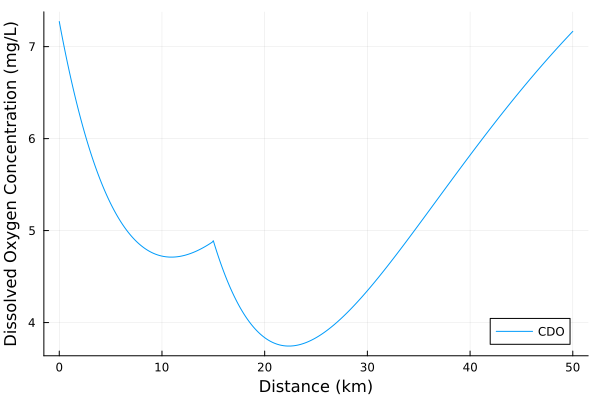

In [193]:
plot(x, CDO, legend=true, bins=6, label="CDO")
ylabel!("Dissolved Oxygen Concentration (mg/L)")
xlabel!("Distance (km)")

# Plots CBOD and NBOD if needed
# plot!(x, CBOD, legend=false, bins=6, label="CBOD")
# plot!(x, NBOD, legend=false, bins=6, label="NBOD")

Concentration of BOD decreases drastically at each waste site, then begins to recover after about 10 km past each site. The CBOD is at a minimum after waste site 2, at about 22 km downstream.

### Problem 3 (3 points)

Under the assumptions of Problem 1, determine the distance from waste
stream 2 it will take for the dissolved oxygen concentration of the
river to recover to 6 mg/L.

In [194]:
for i in 150:length(CDO) # evalulates if CDO is greater than 6 at every x past 15.0
    if CDO[i] > 6
    println(round(i * 0.1, digits = 3), " km") # since step size in x is 0.1, final x should be multiplied by 0.1
    break # break for loop once condition has been met
    end
end

41.4 km


### Problem 4 (5 points)

What is the minimum level of treatment (% removal of organic waste) for
waste stream 2 that will ensure that the dissolved oxygen concentration
never drops below 4 mg/L, assuming that waste stream 1 remains
untreated?

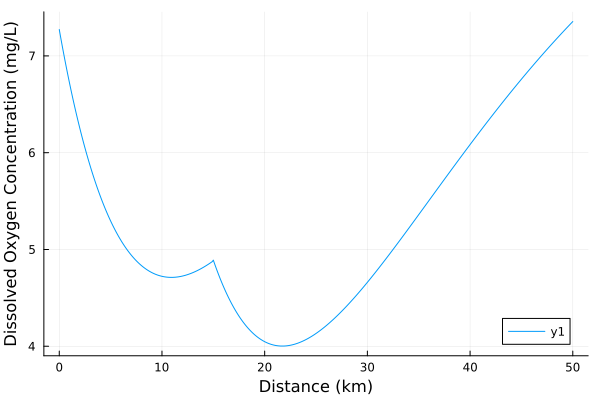

In [195]:
# Calculate Initial Conditions
C0 = (C_river * Q_river + C_waste1 * Q_waste1) / (Q_river + Q_waste1);
B0 = (B0_river * Q_river + B0_waste1 * Q_waste1) / (Q_river + Q_waste1);
N0 = (N0_river * Q_river + N0_waste1 * Q_waste1) / (Q_river + Q_waste1);

x = []; # list of x values
CDO = []; # list for Dissolved Oxygen Concentrations
CBOD = []; # list of Bio oxygen demands
NBOD = []; # list of NBOD


# Model from x = 1 to 14.9
for i = 0:0.1:14.9 # ends at 14.9 to prevent double counting of x = 15 in next for loop

    alpha_1 = exp(-ka * i / U);
    alpha_2 = (kc / (ka - kc)) * (exp(-kc * i / U) - alpha_1);
    alpha_3 = (kn / (ka - kn)) * (exp(-kn * i / U) - alpha_1);
    
    C = ((C_s * (1 - alpha_1)) + (C0 * alpha_1) - (B0 * alpha_2) - (N0 * alpha_3)); # calculates CDO
    B = B0 * exp(-kc * i / U); # calculates CBOD
    N = N0 * exp(-kn * i / U); # calculates NBOD

    append!(CDO, C); #Adds calculated Concentration to List of CDOs
    append!(CBOD, B);
    append!(NBOD, N);
    append!(x, i) #Adds x value
end

# Calculate new initial conditions at waste site 2 from conditions at x = 15
# Percent Removal of CBOD and NBOD
Percent_removal = 0.072

C0 = (last(CDO) * (Q_river + Q_waste1) + C_waste2 * Q_waste2) / (Q_river + Q_waste1 + Q_waste2);
B0 = (1 - Percent_removal) * (last(CBOD) * (Q_river + Q_waste1) + B0_waste2 * Q_waste2) / (Q_river + Q_waste1 + Q_waste2);
N0 = (1 - Percent_removal) * (last(NBOD) * (Q_river + Q_waste1) + N0_waste2 * Q_waste2) / (Q_river + Q_waste1 + Q_waste2);


# Model from x = 15 to 50 km

for i = 15:0.1:50
    alpha_1 = exp(-ka * (i-15) / U); # subtract 15 from i so that it starts calculation at i = 0
    alpha_2 = (kc / (ka - kc)) * (exp(-kc * (i-15) / U) - alpha_1);
    alpha_3 = (kn / (ka - kn)) * (exp(-kn * (i-15) / U) - alpha_1);

    C = ((C_s * (1 - alpha_1)) + (C0 * alpha_1) - (B0 * alpha_2) - (N0 * alpha_3)); # calculates CDO
    B = B0 * exp(-kc * (i-15) / U); # calculates BOD
    N = N0 * exp(-kn * (i-15) / U); # calculates NBOD


    append!(CDO, C); #Adds calculated Concentration to List of CDOs
    append!(CBOD, B);
    append!(NBOD, N);
    append!(x, i) #Adds x value

end

plot(x, CDO)
ylabel!("Dissolved Oxygen Concentration (mg/L)")
xlabel!("Distance (km)")

In [196]:
println(round(Percent_removal * 100, digits = 3), "% organic waste removal results in a minimum CDO of ", round(minimum(CDO), digits = 3))

7.2% organic waste removal results in a minimum CDO of 4.002


The minimum percent of CBOD and NBOD removal is 7.2% to ensure that CDO does not drop below 4 mg/L.
This was evaluated by multiplying the B0 and N0 at waste stream 2 by (1 - percent removal) until the minium CDO was above 4.

### Problem 5 (5 points)

If both waste streams are treated equally, what is the minimum level of
treatment (% removal of organic waste) for the two sources required to
ensure that the dissolved oxygen concentration never drops below 4 mg/L?

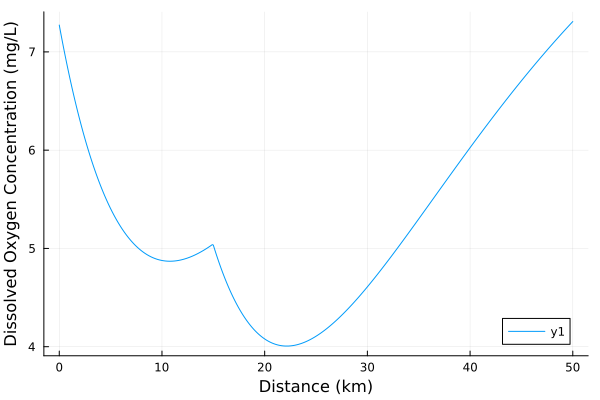

In [197]:
# Calculate Initial Conditions with percent Removal

Percent_removal = 0.037

C0 = (C_river * Q_river + C_waste1 * Q_waste1) / (Q_river + Q_waste1);
B0 = (1 - Percent_removal) * (B0_river * Q_river + B0_waste1 * Q_waste1) / (Q_river + Q_waste1); # includes (1-percent removal) in calculation
N0 = (1 - Percent_removal) * (N0_river * Q_river + N0_waste1 * Q_waste1) / (Q_river + Q_waste1);

x = []; # list of x values
CDO = []; # list for Dissolved Oxygen Concentrations
CBOD = []; # list of Bio oxygen demands
NBOD = []; # list of NBOD


# Model from x = 1 to 14.9
for i = 0:0.1:14.9 # ends at 14.9 to prevent double counting of x = 15 in next for loop

    alpha_1 = exp(-ka * i / U);
    alpha_2 = (kc / (ka - kc)) * (exp(-kc * i / U) - alpha_1);
    alpha_3 = (kn / (ka - kn)) * (exp(-kn * i / U) - alpha_1);
    
    C = ((C_s * (1 - alpha_1)) + (C0 * alpha_1) - (B0 * alpha_2) - (N0 * alpha_3)); # calculates CDO
    B = B0 * exp(-kc * i / U); # calculates CBOD
    N = N0 * exp(-kn * i / U); # calculates NBOD

    append!(CDO, C); #Adds calculated Concentration to List of CDOs
    append!(CBOD, B);
    append!(NBOD, N);
    append!(x, i) #Adds x value
end

# Calculate new initial conditions at waste site 2 from conditions at x = 15
#Percent Removal of CBOD and NBOD

C0 = (last(CDO) * (Q_river + Q_waste1) + C_waste2 * Q_waste2) / (Q_river + Q_waste1 + Q_waste2);
B0 = (1 - Percent_removal) * (last(CBOD) * (Q_river + Q_waste1) + B0_waste2 * Q_waste2) / (Q_river + Q_waste1 + Q_waste2);
N0 = (1 - Percent_removal) * (last(NBOD) * (Q_river + Q_waste1) + N0_waste2 * Q_waste2) / (Q_river + Q_waste1 + Q_waste2);

# Model from x = 15 to 50 km

for i = 15:0.1:50
    alpha_1 = exp(-ka * (i-15) / U); # subtract 15 from i so that it starts calculation at i = 0
    alpha_2 = (kc / (ka - kc)) * (exp(-kc * (i-15) / U) - alpha_1);
    alpha_3 = (kn / (ka - kn)) * (exp(-kn * (i-15) / U) - alpha_1);

    C = ((C_s * (1 - alpha_1)) + (C0 * alpha_1) - (B0 * alpha_2) - (N0 * alpha_3)); # calculates CDO
    B = B0 * exp(-kc * (i-15) / U); # calculates BOD
    N = N0 * exp(-kn * (i-15) / U); # calculates NBOD


    append!(CDO, C); #Adds calculated Concentration to List of CDOs
    append!(CBOD, B);
    append!(NBOD, N);
    append!(x, i) #Adds x value

end

plot(x, CDO)
ylabel!("Dissolved Oxygen Concentration (mg/L)")
xlabel!("Distance (km)")

In [198]:
println(round(Percent_removal * 100, digits = 3), "% organic waste removal results in a minimum CDO of ", round(minimum(CDO), digits = 3))

3.7% organic waste removal results in a minimum CDO of 4.007


The minimum percent removal at both sites 1 and 2 is 3.7%. This was evalulated the same way as in problem 5

### Problem 6 (5 points)

Suppose you are responsible for designing a waste treatment plan for
discharges into the river, with a regulatory mandate to keep the
dissolved oxygen concentration above 4 mg/L. Discuss whether you’d opt
to treat waste stream 2 alone or both waste streams equally. What other
information might you need to make a conclusion, if any?

My answer depends on how the treatment is being paid for. If this is an operation by the regulatory agency or the municipality, I would opt to use a singular treatment plant instead of two treatment plants to keep CDO above regulatory standards. Using one treatment system requires a higher percentage of organic waste removal, but it would be cheaper to construct only one treatment plant.

However, if the companies were responsible for using their own resources to keep the CDO above regulation, I would recommend that both waste sites must contribute equally to treatment. Although the CDO goes below regulatory standards after site 2, both sites 1 and 2 contributed similarly to adding organic waste to the river; therefore, they should contribute equally to treatment. 

### Problem 7 (5 points)

Suppose that it is known that the DO concentrations at the river inflow
can vary uniformly between 6 mg/L and 8 mg/L. How often will the
treatment plan identified in Problem 5 (both waste streams treated
equally) fail to comply with the regulatory standard?

Since inflow concentrations are distributed uniformly, instead of doing a Monte Carlo simulation, we can just evaluate final concentrations using a for loop which evaluates minimum CDO with initial inflows ranging from 6 to 8.

In [199]:
C_rivers = 6:0.01:8 # evaluates once for each step between 6 and 8 with a step size of 0.1
fails = 0; # counter for number of times minimum CDO goes below 4
pass = 0; # counter for passing CDO minimum level

for C_initial in C_rivers

    # Calculate Initial Conditions
    Percent_removal = 0.037

    C0 = (C_initial * Q_river + C_waste1 * Q_waste1) / (Q_river + Q_waste1);
    B0 = (1 - Percent_removal) * (B0_river * Q_river + B0_waste1 * Q_waste1) / (Q_river + Q_waste1); # includes (1-percent removal) in calculation
    N0 = (1 - Percent_removal) * (N0_river * Q_river + N0_waste1 * Q_waste1) / (Q_river + Q_waste1);


    x = []; # list of x values
    CDO = []; # list for Dissolved Oxygen Concentrations
    CBOD = []; # list of Bio oxygen demands
    NBOD = []; # list of NBOD


    # Model from x = 1 to 14.9
    for i = 0:0.1:14.9 # ends at 14.9 to prevent double counting of x = 15 in next for loop

        alpha_1 = exp(-ka * i / U);
        alpha_2 = (kc / (ka - kc)) * (exp(-kc * i / U) - alpha_1);
        alpha_3 = (kn / (ka - kn)) * (exp(-kn * i / U) - alpha_1);
        
        C = ((C_s * (1 - alpha_1)) + (C0 * alpha_1) - (B0 * alpha_2) - (N0 * alpha_3)); # calculates CDO
        B = B0 * exp(-kc * i / U); # calculates CBOD
        N = N0 * exp(-kn * i / U); # calculates NBOD

        append!(CDO, C); #Adds calculated Concentration to List of CDOs
        append!(CBOD, B);
        append!(NBOD, N);
        append!(x, i) #Adds x value
    end

    # Calculate new initial conditions at waste site 2 from conditions at x = 15

    C0 = (last(CDO) * (Q_river + Q_waste1) + C_waste2 * Q_waste2) / (Q_river + Q_waste1 + Q_waste2);
    B0 = (1 - Percent_removal) * (last(CBOD) * (Q_river + Q_waste1) + B0_waste2 * Q_waste2) / (Q_river + Q_waste1 + Q_waste2);
    N0 = (1 - Percent_removal) * (last(NBOD) * (Q_river + Q_waste1) + N0_waste2 * Q_waste2) / (Q_river + Q_waste1 + Q_waste2);

    # Model from x = 15 to 50 km

    for i = 15:0.1:50
        alpha_1 = exp(-ka * (i-15) / U); # subtract 15 from i so that it starts calculation at i = 0
        alpha_2 = (kc / (ka - kc)) * (exp(-kc * (i-15) / U) - alpha_1);
        alpha_3 = (kn / (ka - kn)) * (exp(-kn * (i-15) / U) - alpha_1);

        C = ((C_s * (1 - alpha_1)) + (C0 * alpha_1) - (B0 * alpha_2) - (N0 * alpha_3)); # calculates CDO
        B = B0 * exp(-kc * (i-15) / U); # calculates BOD
        N = N0 * exp(-kn * (i-15) / U); # calculates NBOD


        append!(CDO, C); #Adds calculated Concentration to List of CDOs
        append!(CBOD, B);
        append!(NBOD, N);
        append!(x, i) #Adds x value
    end

    if minimum(CDO) < 4
        fails += 1;
    end

    if minimum(CDO) > 4
        pass += 1;
    end
end

failure_rate = fails/(fails + pass);
println("failure rate is ", failure_rate)


failure rate is 0.7164179104477612


### Problem 8 (5 points)

A factory is planning a third wastewater discharge into the river
downstream of the second plant. This discharge would consist of 5
m<sup>3</sup>/day of wastewater with a dissolved oxygen content of 4.5
mg/L and CBOD and NBOD levels of 50 and 45 mg/L, respectively.

Assume that the treatment plan you identified in Problem 5 is still in
place for the existing discharges. If the third discharge will not be
treated, under the original inflow conditions (7.5 mg/L DO), how far
downstream from the second discharge does this third discharge need to
be placed to keep the river concentration from dropping below 4 mg/L?

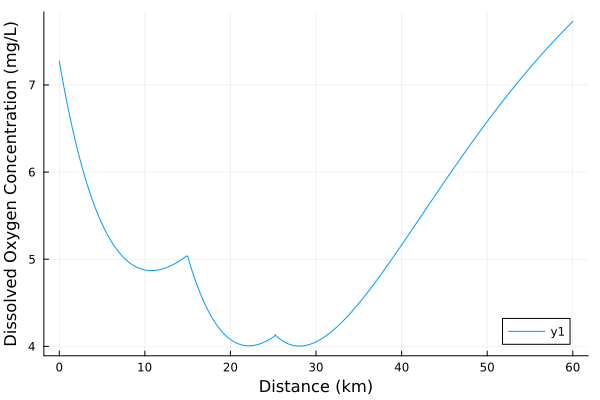

In [200]:
x_3 = 25.2; # x_3 is the x distance of the third plant
C_waste3 = 4.5
B0_waste3 = 50
N0_waste3 = 45
Q_waste3 = 5000 # L/day discharge


# Calculate Initial Conditions with percent Removal

Percent_removal = 0.037

C0 = (C_river * Q_river + C_waste1 * Q_waste1) / (Q_river + Q_waste1);
B0 = (1 - Percent_removal) * (B0_river * Q_river + B0_waste1 * Q_waste1) / (Q_river + Q_waste1); # includes (1-percent removal) in calculation
N0 = (1 - Percent_removal) * (N0_river * Q_river + N0_waste1 * Q_waste1) / (Q_river + Q_waste1);

x = []; # list of x values
CDO = []; # list for Dissolved Oxygen Concentrations
CBOD = []; # list of Bio oxygen demands
NBOD = []; # list of NBOD


# Model from x = 1 to 14.9
for i = 0:0.1:14.9 # ends at 14.9 to prevent double counting of x = 15 in next for loop

    alpha_1 = exp(-ka * i / U);
    alpha_2 = (kc / (ka - kc)) * (exp(-kc * i / U) - alpha_1);
    alpha_3 = (kn / (ka - kn)) * (exp(-kn * i / U) - alpha_1);
    
    C = ((C_s * (1 - alpha_1)) + (C0 * alpha_1) - (B0 * alpha_2) - (N0 * alpha_3)); # calculates CDO
    B = B0 * exp(-kc * i / U); # calculates CBOD
    N = N0 * exp(-kn * i / U); # calculates NBOD

    append!(CDO, C); #Adds calculated Concentration to List of CDOs
    append!(CBOD, B);
    append!(NBOD, N);
    append!(x, i) #Adds x value
end

# Calculate new initial conditions at waste site 2 from conditions at x = 15
#Percent Removal of CBOD and NBOD

C0 = (last(CDO) * (Q_river + Q_waste1) + C_waste2 * Q_waste2) / (Q_river + Q_waste1 + Q_waste2);
B0 = (1 - Percent_removal) * (last(CBOD) * (Q_river + Q_waste1) + B0_waste2 * Q_waste2) / (Q_river + Q_waste1 + Q_waste2);
N0 = (1 - Percent_removal) * (last(NBOD) * (Q_river + Q_waste1) + N0_waste2 * Q_waste2) / (Q_river + Q_waste1 + Q_waste2);

# Model from x = 15 to 50 km

for i = 15:0.1:x_3
    alpha_1 = exp(-ka * (i-15) / U); # subtract 15 from i so that it starts calculation at i = 0
    alpha_2 = (kc / (ka - kc)) * (exp(-kc * (i-15) / U) - alpha_1);
    alpha_3 = (kn / (ka - kn)) * (exp(-kn * (i-15) / U) - alpha_1);

    C = ((C_s * (1 - alpha_1)) + (C0 * alpha_1) - (B0 * alpha_2) - (N0 * alpha_3)); # calculates CDO
    B = B0 * exp(-kc * (i-15) / U); # calculates BOD
    N = N0 * exp(-kn * (i-15) / U); # calculates NBOD


    append!(CDO, C); #Adds calculated Concentration to List of CDOs
    append!(CBOD, B);
    append!(NBOD, N);
    append!(x, i) #Adds x value

end


# Calculate new initial conditions at x = x_3

C0 = (last(CDO) * (Q_river + Q_waste1 + Q_waste2) + C_waste3 * Q_waste3) / (Q_river + Q_waste1 + Q_waste2 + Q_waste3);
B0 = (last(CBOD) * (Q_river + Q_waste1 + Q_waste2) + B0_waste3 * Q_waste3) / (Q_river + Q_waste1 + Q_waste2 + Q_waste3);
N0 = (last(NBOD) * (Q_river + Q_waste1 + Q_waste2) + N0_waste3 * Q_waste3) / (Q_river + Q_waste1 + Q_waste2 + Q_waste3);

for i = x_3:0.1:60
    alpha_1 = exp(-ka * (i-x_3) / U); # subtract 15 from i so that it starts calculation at i = 0
    alpha_2 = (kc / (ka - kc)) * (exp(-kc * (i-x_3) / U) - alpha_1);
    alpha_3 = (kn / (ka - kn)) * (exp(-kn * (i-x_3) / U) - alpha_1);

    C = ((C_s * (1 - alpha_1)) + (C0 * alpha_1) - (B0 * alpha_2) - (N0 * alpha_3)); # calculates CDO
    B = B0 * exp(-kc * (i-x_3) / U); # calculates BOD
    N = N0 * exp(-kn * (i-x_3) / U); # calculates NBOD


    append!(CDO, C); #Adds calculated Concentration to List of CDOs
    append!(CBOD, B);
    append!(NBOD, N);
    append!(x, i) #Adds x value

end


plot(x, CDO)
ylabel!("Dissolved Oxygen Concentration (mg/L)")
xlabel!("Distance (km)")

In [201]:
println(minimum(CDO), " mg/L minimum CDO");
println(x_3, " km downstream for waste site 3")


4.003643901073528 mg/L minimum CDO
25.2 km downstream for waste site 3


Using the treatment plan which treats both site 1 and 2 with 3.7% organic waste removal, the third plant would need to be 25.2 km downstream to keep CDO above 4.0

## References

List any external references consulted, including classmates.